# Problem Set 2

Natasha Watkins

### Exercise 8

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
lipids = pd.read_csv('lipids.csv', skiprows=4)

In [3]:
lipids = lipids[lipids.diseased == 1]
lipids.head()

,diseased,chol,trig
51,1,184,145
52,1,263,142
53,1,185,115
54,1,271,128
55,1,173,56


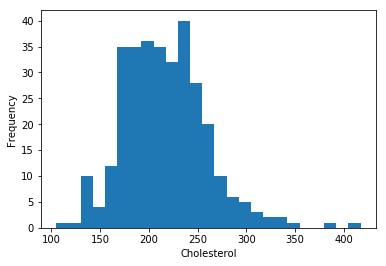

In [4]:
counts, bins, _ = plt.hist(lipids['chol'], bins=25)
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')
plt.show()

The mid-point of the highest frequency bin is...

In [5]:
bins[[counts.argmax(), counts.argmax()+1]].mean()

236.04000000000002

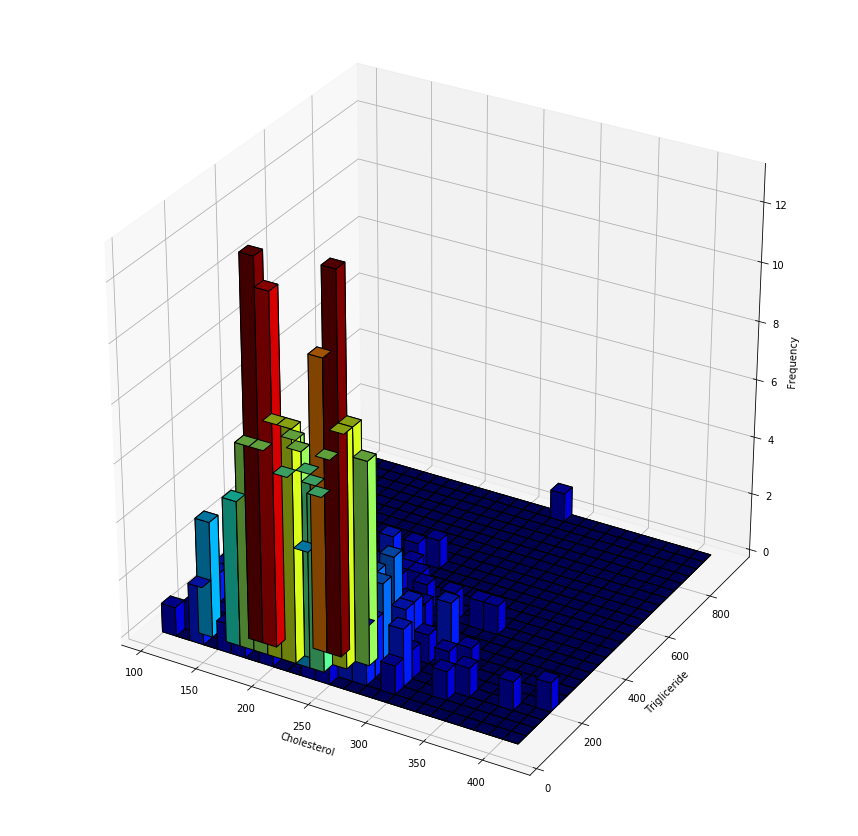

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(lipids['chol'], lipids['trig'], bins=25)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
dz = hist.flatten()

cmap = cm.get_cmap('jet')
max_height = np.max(dz)
min_height = np.min(dz)

rgba = [cmap((k - min_height) / max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average', edgecolor='k')
plt.xlabel("Cholesterol")
plt.ylabel("Trigliceride")
ax.set_zlabel('Frequency')

plt.show()

From the plot, we can see that low triglicerides and cholesterol levels are positively correlated

### Exercise 9

In [15]:
n_series = 14

payems = pd.read_csv('payems.csv', index_col=0)
y2k = payems.index.get_loc('1/1/00')  # Century change
payems_before = payems[:y2k]
payems_after = payems[y2k:]

# Functions for modifying dates
repl_1 = lambda s: '19' + s.group(0)
repl_2 = lambda s: '20' + s.group(0)

# Replace dates with full years to prevent pandas interpreting as wrong century
payems_before.index = payems_before.index.str.replace('(\d\d)$', repl_1)
payems_after.index = payems_after.index.str.replace('(\d\d)$', repl_2)
payems = pd.concat([payems_before, payems_after])
payems.index = pd.to_datetime(payems.index)

In [16]:
payems = payems.resample('MS').ffill()  # Resample for monthly data

In [17]:
from fredapi import Fred
fred = Fred(api_key='16fc433e0cb217bb8cb94bf76b981f2f') # Need to register for API key

# Fetch NBER recessions data
indicator = fred.get_series('USREC')

# Find points of change
diff = indicator.diff()

# Find dates where recession started
peak_dates = diff[diff == 1][-n_series:].index

In [24]:
start_dates = peak_dates - pd.offsets.DateOffset(years=1)
end_dates = start_dates + pd.offsets.DateOffset(years=10, months=5)
series = []

# Create series of recessions
for start, end in zip(start_dates, end_dates):
    series.append(payems[str(start):str(end)])

In [25]:
new_series = []

for i in range(n_series):
    p = peak_dates[i]
    norm = series[i].loc[p]
    norm_series = series[i] / norm
    
    # Create an index range with 0 at a series value equal to 1
    after = norm_series[p:]
    before = norm_series[:p]
    before.index = range(-len(before)+1, 1)
    after.index = range(1, len(after)+1)
    new_series.append(pd.concat([before, after]))

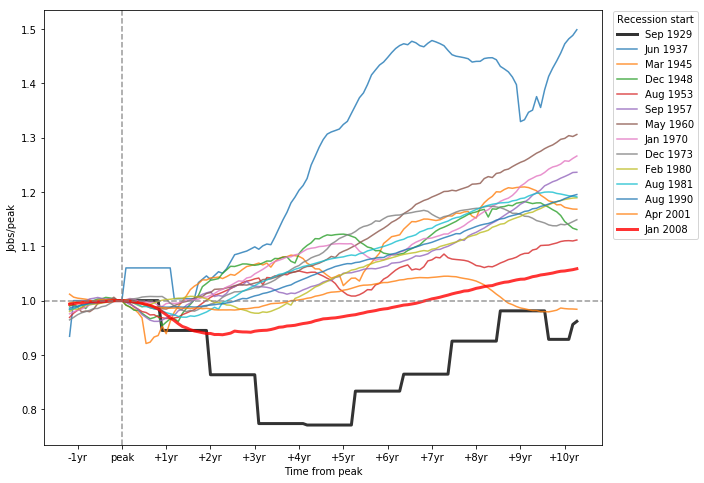

In [26]:
plt.figure(figsize=(10, 8))

for s, peak_date in zip(new_series, peak_dates):
    if peak_date.year == 1929:
        plt.plot(s, label=peak_date.strftime('%b %Y'), 
                 alpha=0.8, c='k', lw=3)
    elif peak_date.year == 2008:
        plt.plot(s, label=peak_date.strftime('%b %Y'), 
                 alpha=0.8, c='r', lw=3)
    else:
        plt.plot(s, label=peak_date.strftime('%b %Y'), 
                 alpha=0.8)
    
plt.axvline(x=1, c='gray', ls='--', alpha=0.8)
plt.axhline(y=1, c='gray', ls='--', alpha=0.8)
    
plt.legend(bbox_to_anchor=(1.18, 1.01), title='Recession start')
plt.ylabel('Jobs/peak')
plt.xlabel('Time from peak')
plt.xticks(np.arange(-10, 120, 11), 
           ['-1yr', 'peak', '+1yr', '+2yr', 
            '+3yr', '+4yr', '+5yr', '+6yr', 
            '+7yr', '+8yr', '+9yr', '+10yr'])
plt.show()

The plot shows that, besides the Great Depression, jobs took longer to recover during the Great Recession than any other recession.